In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tifffile as tiff
import json
import pyproj
from PIL import Image,ImageDraw
import json
import math

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
import shutil
import pandas as pd

from torch.utils.data import Dataset
import xml.etree.ElementTree as et
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn


import time
from matplotlib.patches import Rectangle
import segmentation_models_pytorch as smp
from torch.cuda import amp
from collections import defaultdict
import copy
import random



import albumentations as A # optimizer https://hoya012.github.io/blog/albumentation_tutorial/

# 25cm, 0.25m 는 25*25 사이즈의 크기가 점으로 표현 가능한 해상도를 뜻함함
# tiff 데이터는 np.array 로 넘파이화 시키면 될듯

c:\Users\LG\anaconda3\envs\sw_acp\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
size = 512
train_batch_size = 10
valid_batch_size = train_batch_size*2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
backbone = 'efficientnet-b0'
num_classes = 10
n_accumulate  = max(1, 32//train_batch_size)
lr = 2e-3
min_lr = 1e-6
epochs = 10
scheduler_name = 'CosineAnnealingLR'
T_max = int(30000/train_batch_size*epochs)+50
T_0 = 25
warmup_epochs = 0
wd = 1e-6
exp_name = '2.5D'
comment = 'unet-efficientnet_b0-160x192-ep=5'
model_name = 'Unet'
n_fold = 5
folds = [0]


"""
class CFG:

    exp_name      = '2.5D'
    comment       = 'unet-efficientnet_b0-160x192-ep=5'
    model_name    = 'Unet'

    n_fold        = 5
    folds         = [0]

"""

"\nclass CFG:\n\n    exp_name      = '2.5D'\n    comment       = 'unet-efficientnet_b0-160x192-ep=5'\n    model_name    = 'Unet'\n\n    n_fold        = 5\n    folds         = [0]\n\n"

In [3]:
def load_img(path="C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_001_2019_FGT.npy"):
    image_path = path
    img = np.load(image_path)
    
    img = img.astype('float32')
    mx = np.max(img)
    if mx:
        img/=mx
        
    img = np.transpose(img,(2, 0, 1)) # shape 의 0,1,2번째를 순서를 바꿈
    print(img.shape)
    img = torch.tensor([img])
    
    return img

In [4]:
def load_img_bypath(path):
    image_path = path
    img = Image.open(image_path)
    w,h=img.size
    exponent = int(int(math.log(w*h,2))/2)
    sl = 2**max(5,exponent)
    img = img.resize((sl,sl))
    img = np.array(img)
    
    
    img = img.astype('float32')
    mx = np.max(img)
    if mx:
        img/=mx
        
    img = np.transpose(img,(2, 0, 1)) # shape 의 0,1,2번째를 순서를 바꿈
    #print(img.shape)
    img = torch.tensor([img])
    
    return img

In [5]:
import segmentation_models_pytorch as smp
# 기본적으로 있는 모드

def build_model():
    model = smp.Unet(
        encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3, #5로 바꿀수있는지 해보기                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [6]:
#classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

rows = 3
cols = 5

model_path = "./best_epoch-05.bin"


#PATH = "C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_068_2019_FGT.npy"


def predict_bypath(PATH):
	img = load_img_bypath(path=PATH)

	preds = []
	for fold in range(1):
		model = load_model(model_path)
		with torch.no_grad():
			pred = model(img.to(device, dtype=torch.float))
			pred = (nn.Sigmoid()(pred)>0.5).double()
		preds.append(pred)
		
	img  = img.cpu().detach().numpy()
	preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach().numpy()
 
	return preds

def predict(PATH):
	img = load_img(path=PATH)

	preds = []
	for fold in range(1):
		model = load_model(model_path)
		with torch.no_grad():
			pred = model(img.to(device, dtype=torch.float))
			pred = (nn.Sigmoid()(pred)>0.5).double()
		preds.append(pred)
		
	img  = img.cpu().detach().numpy()
	preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach().numpy()
 
	return preds


fontsize = 50

COLOR=[[255,0,0], # 빨강 건물
       [246,120,40], # 
       [255,255,0],
       [0,255,0],
       [0,0,255],
       [0,5,255],
       [100,0,255],
       [255,192,203],
       [101,67,33],
       [0,86,102]
       ]
class_name=["건물",
            "주차장","비닐하우스",
            "나지","도로","가로수",
            "밭","산림","농경지","비대상지"]

def path(type,name,size):
	if type=="image":
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}.npy"
	else:
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}/{name}.npy"

def Synthesis_img_mask_bypath(path,idxs=[4],size=1024): # 0<=idx<=9
	img = Image.open(path)
	w,h=img.size
	exponent = int(int(math.log(w*h,2))/2)
	sl = 2**max(5,exponent)
	#print(w,h,sl,exponent)
	#print(w,h,exponent,sl)
	img = img.resize((sl,sl))
	img = np.array(img,"float32")
	fig = plt.figure(figsize=(50,50))
	#img = np.transpose(img,(2,0,1))
	#print("<",img.shape)
	#print(img*255)
	IMG = np.array(img)
	#print(IMG.shape)
	
	synthesis = copy.deepcopy(IMG) 
 
	exist =[0]*10


	#PATH1 = path("mask",name,size)
	#mask = np.load(PATH1)
	#mask = np.transpose(mask,(2,0,1))
	mask = predict_bypath(path)[0]
	#print(mask)
	#print(mask.shape)
 
	for i,idx in enumerate(idxs):
		mask2=np.array(mask,"float32")[idx]
		mask2 = np.array(Image.fromarray(mask2*255).convert("RGB"))
  
		one_synthesis = copy.deepcopy(IMG)
  
		if np.max(mask2)>0:
			exist[idx]=1

		mask2[:,:,0][mask2[:,:,0]!=0]=COLOR[idx][0]
		mask2[:,:,1][mask2[:,:,1]!=0]=COLOR[idx][1]
		mask2[:,:,2][mask2[:,:,2]!=0]=COLOR[idx][2]

		synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])

		one_synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])
  
		ax = fig.add_subplot(rows,cols,i+1)
		imsi_mask = Image.fromarray(one_synthesis.astype(np.uint8))
		ax.imshow(imsi_mask)
		ax.set_title(class_name[idx],fontsize=fontsize)
		ax.axis("off")

	#print(synthesis) 
	#print(synthesis.shape)
	original_img = Image.fromarray((IMG).astype(np.uint8))
	mask3 = Image.fromarray(synthesis.astype(np.uint8))

 
 
	ax1 = fig.add_subplot(rows,cols,11)
	ax1.imshow(original_img)
	ax1.set_title('original',fontsize=fontsize)
	ax1.axis("off")
 
	ax2 = fig.add_subplot(rows,cols,12)
	ax2.imshow(mask3)
	ax2.set_title('mask all',fontsize=fontsize)
	ax2.axis("off")

	#plt.show(original_img)
	#plt.imshow(mask3)
 
	handles = []
	labels = []
	for i in range(10):
		if exist[i]:
			handles.append(Rectangle((0,0),1,1, color=tuple([COLOR[i][j]/255 for j in range(3)])))
			labels.append(class_name[i])
         
 
	plt.legend(handles,labels)
 
	return original_img, mask3, handles, labels
	#plt.axis('off')

In [7]:
def Synthesis_img_mask(name="LC_JJ_AP25_33606070_015_2019_FGT",idxs=[4],size=1024): # 0<=idx<=9
	PATH = path("image",name,size)
	img = np.load(PATH)
	fig = plt.figure(figsize=(50,50))
	#img = np.transpose(img,(2,0,1))
	#print("<",img.shape)
	#print(img*255)
	IMG = np.array(img) * 255
	
	synthesis = copy.deepcopy(IMG) 
 
	exist =[0]*10


	#PATH1 = path("mask",name,size)
	#mask = np.load(PATH1)
	#mask = np.transpose(mask,(2,0,1))
	mask = predict(PATH)[0]
	#print(mask)
	#print(mask.shape)
 
	for i,idx in enumerate(idxs):
		mask2=np.array(mask,"float32")[idx]
		mask2 = np.array(Image.fromarray(mask2*255).convert("RGB"))
  
		one_synthesis = copy.deepcopy(IMG)
  
		if np.max(mask2)>0:
			exist[idx]=1

		mask2[:,:,0][mask2[:,:,0]!=0]=COLOR[idx][0]
		mask2[:,:,1][mask2[:,:,1]!=0]=COLOR[idx][1]
		mask2[:,:,2][mask2[:,:,2]!=0]=COLOR[idx][2]

		synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])

		one_synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])
  
		ax = fig.add_subplot(rows,cols,i+1)
		imsi_mask = Image.fromarray(one_synthesis.astype(np.uint8))
		ax.imshow(imsi_mask)
		ax.set_title(class_name[idx],fontsize=fontsize)
		ax.axis("off")

	#print(synthesis)
	#print(synthesis.shape)
	original_img = Image.fromarray((IMG).astype(np.uint8))
	mask3 = Image.fromarray(synthesis.astype(np.uint8))
 
 
	ax1 = fig.add_subplot(rows,cols,11)
	ax1.imshow(original_img)
	ax1.set_title('original',fontsize=fontsize)
	ax1.axis("off")
 
	ax2 = fig.add_subplot(rows,cols,12)
	ax2.imshow(mask3)
	ax2.set_title('mask all',fontsize=fontsize)
	ax2.axis("off")

	#plt.show(original_img)
	#plt.imshow(mask3)
 
	handles = []
	labels = []
	for i in range(10):
		if exist[i]:
			handles.append(Rectangle((0,0),1,1, color=tuple([COLOR[i][j]/255 for j in range(3)])))
			labels.append(class_name[i])
         
 
	plt.legend(handles,labels,fontsize=30)
	#plt.axis('off')
 
	return original_img, mask3, handles, labels

In [8]:
""" Synthesis_img_mask(name="LC_JJ_AP25_33606070_016_2019_FGT",
                   idxs=[i for i in range(10)],size=1024) """

' Synthesis_img_mask(name="LC_JJ_AP25_33606070_016_2019_FGT",\n                   idxs=[i for i in range(10)],size=1024) '

C:\Users\LG\AppData\Local\Temp\ipykernel_17560\62530097.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  img = torch.tensor([img])
C:\Users\LG\AppData\Local\Temp\ipykernel_17560\1020412075.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no 

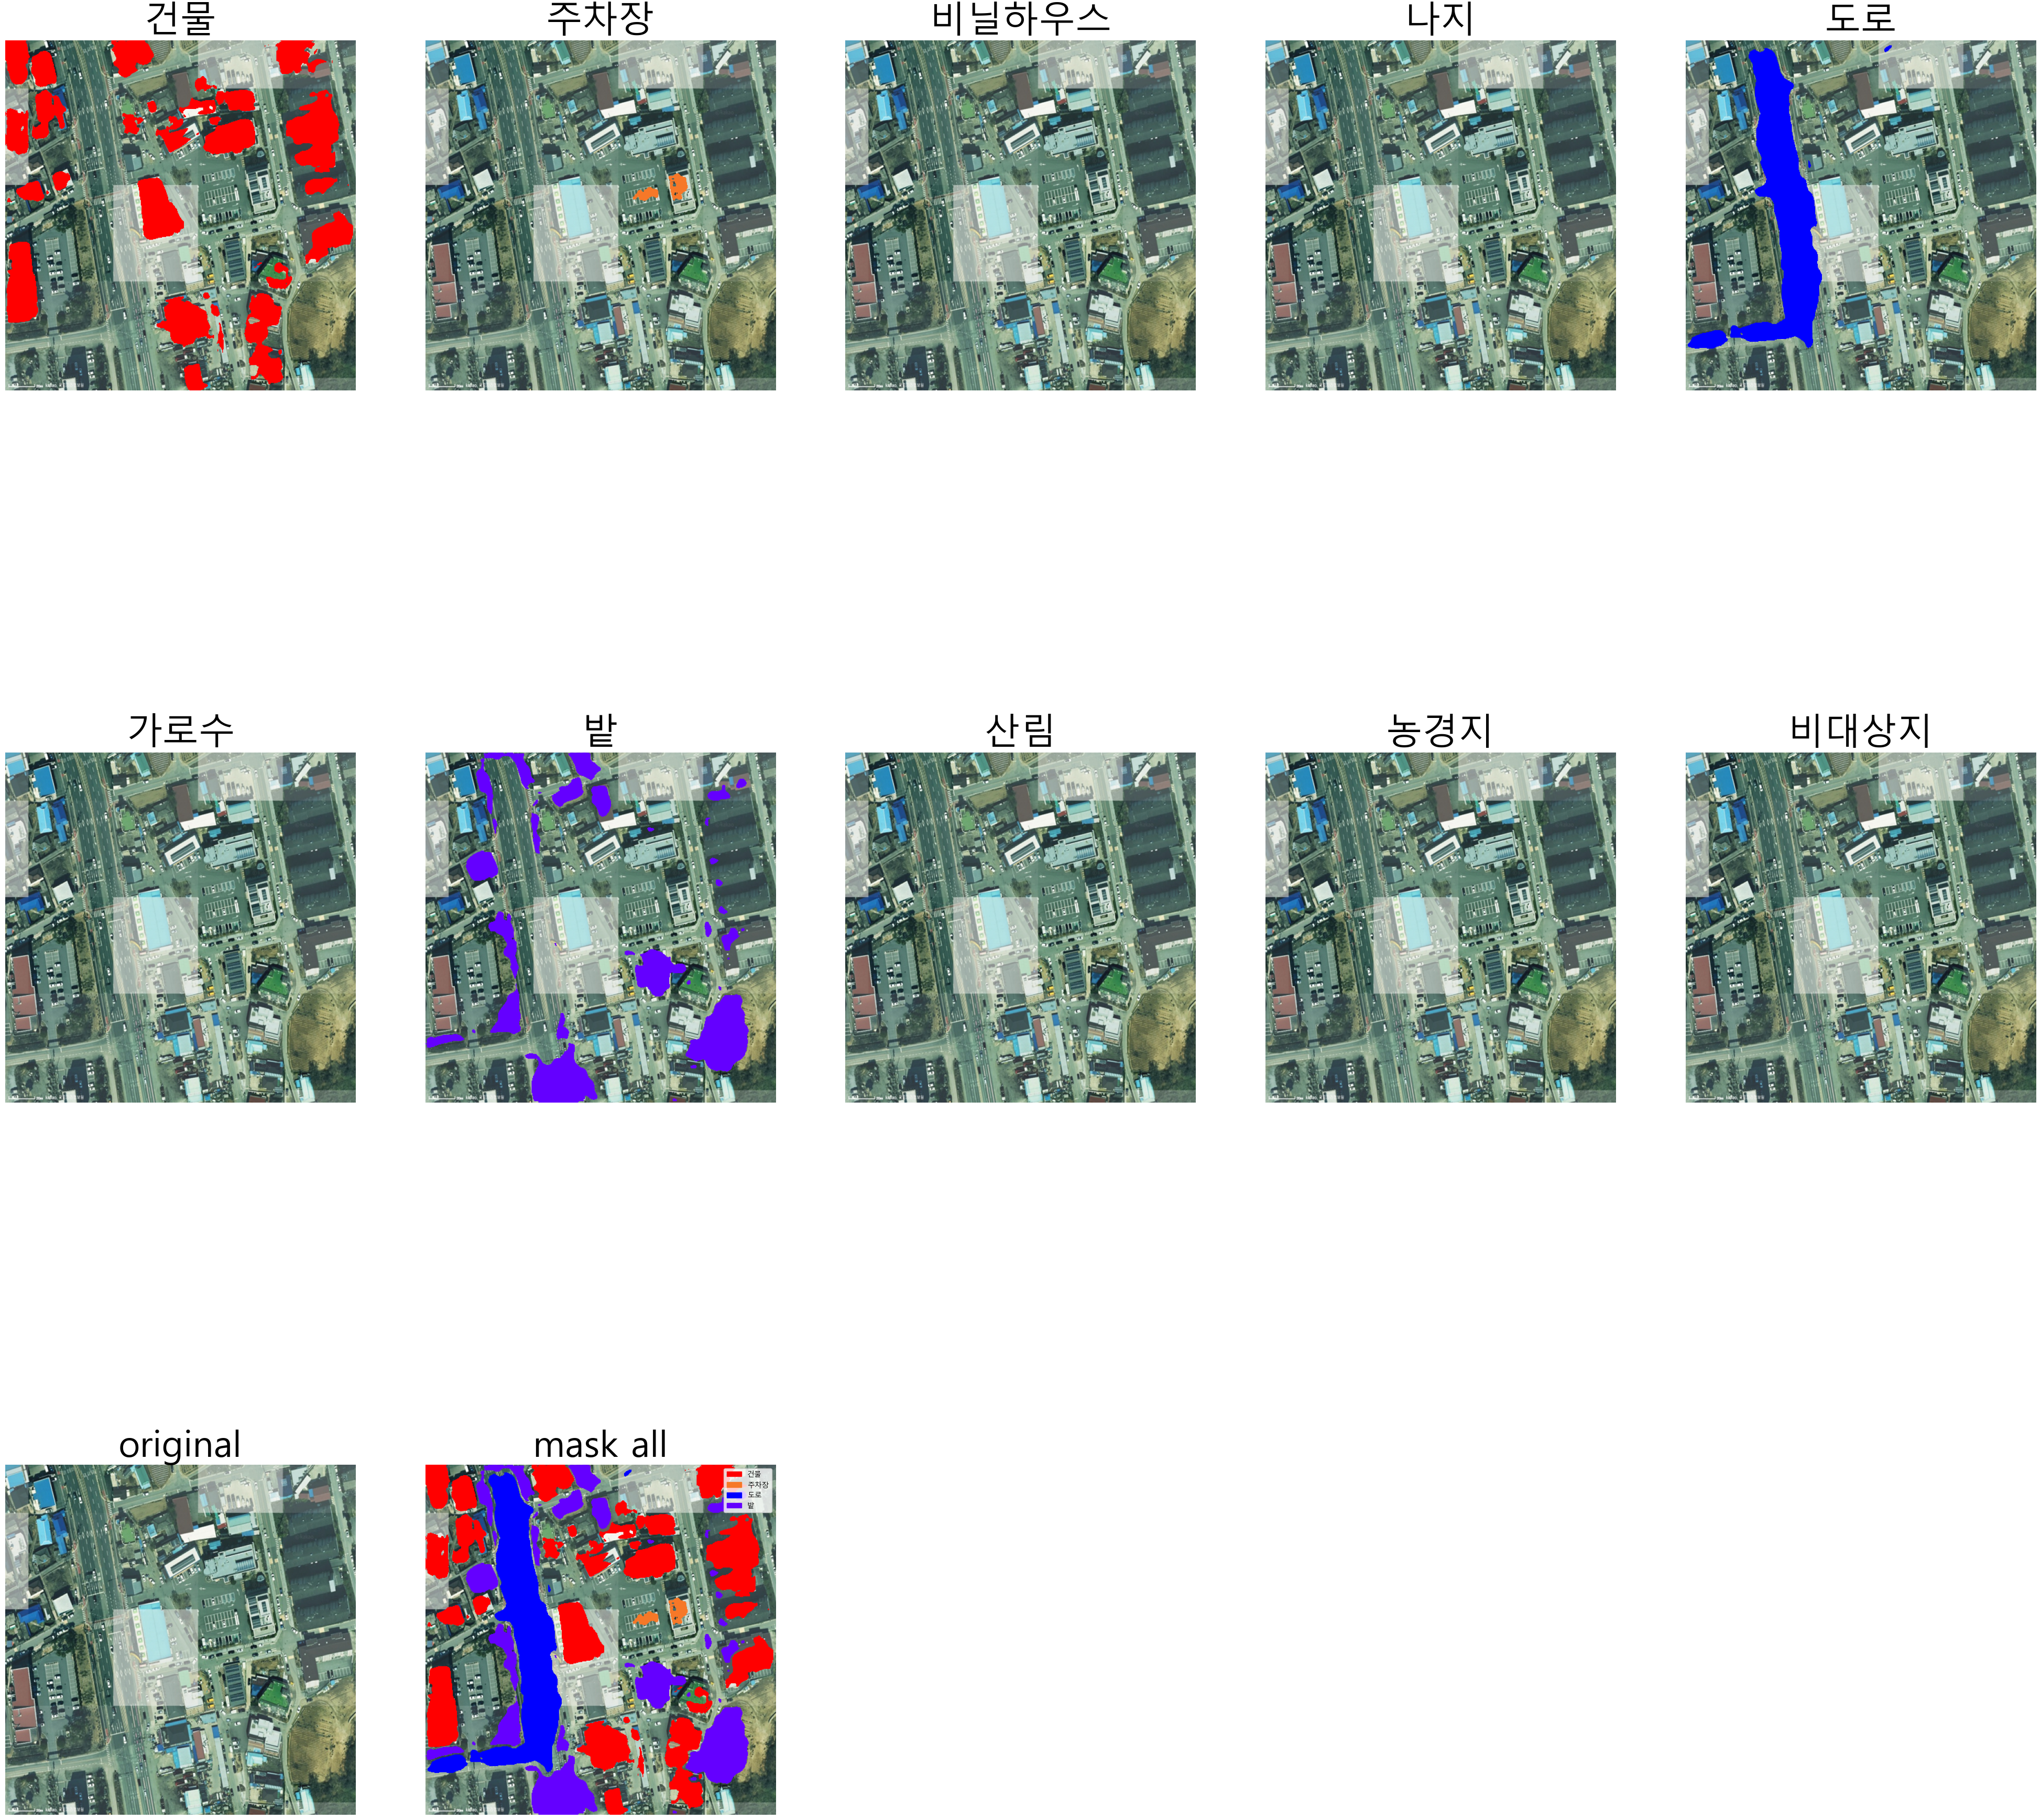

In [9]:
original_img, mask3, handles, labels = Synthesis_img_mask_bypath(path="./imgdata2.jpg",
                   idxs=[i for i in range(10)],size=1024)

#original_img = Image.fromarray(original_img)
#mask3 = Image.fromarray(mask3)

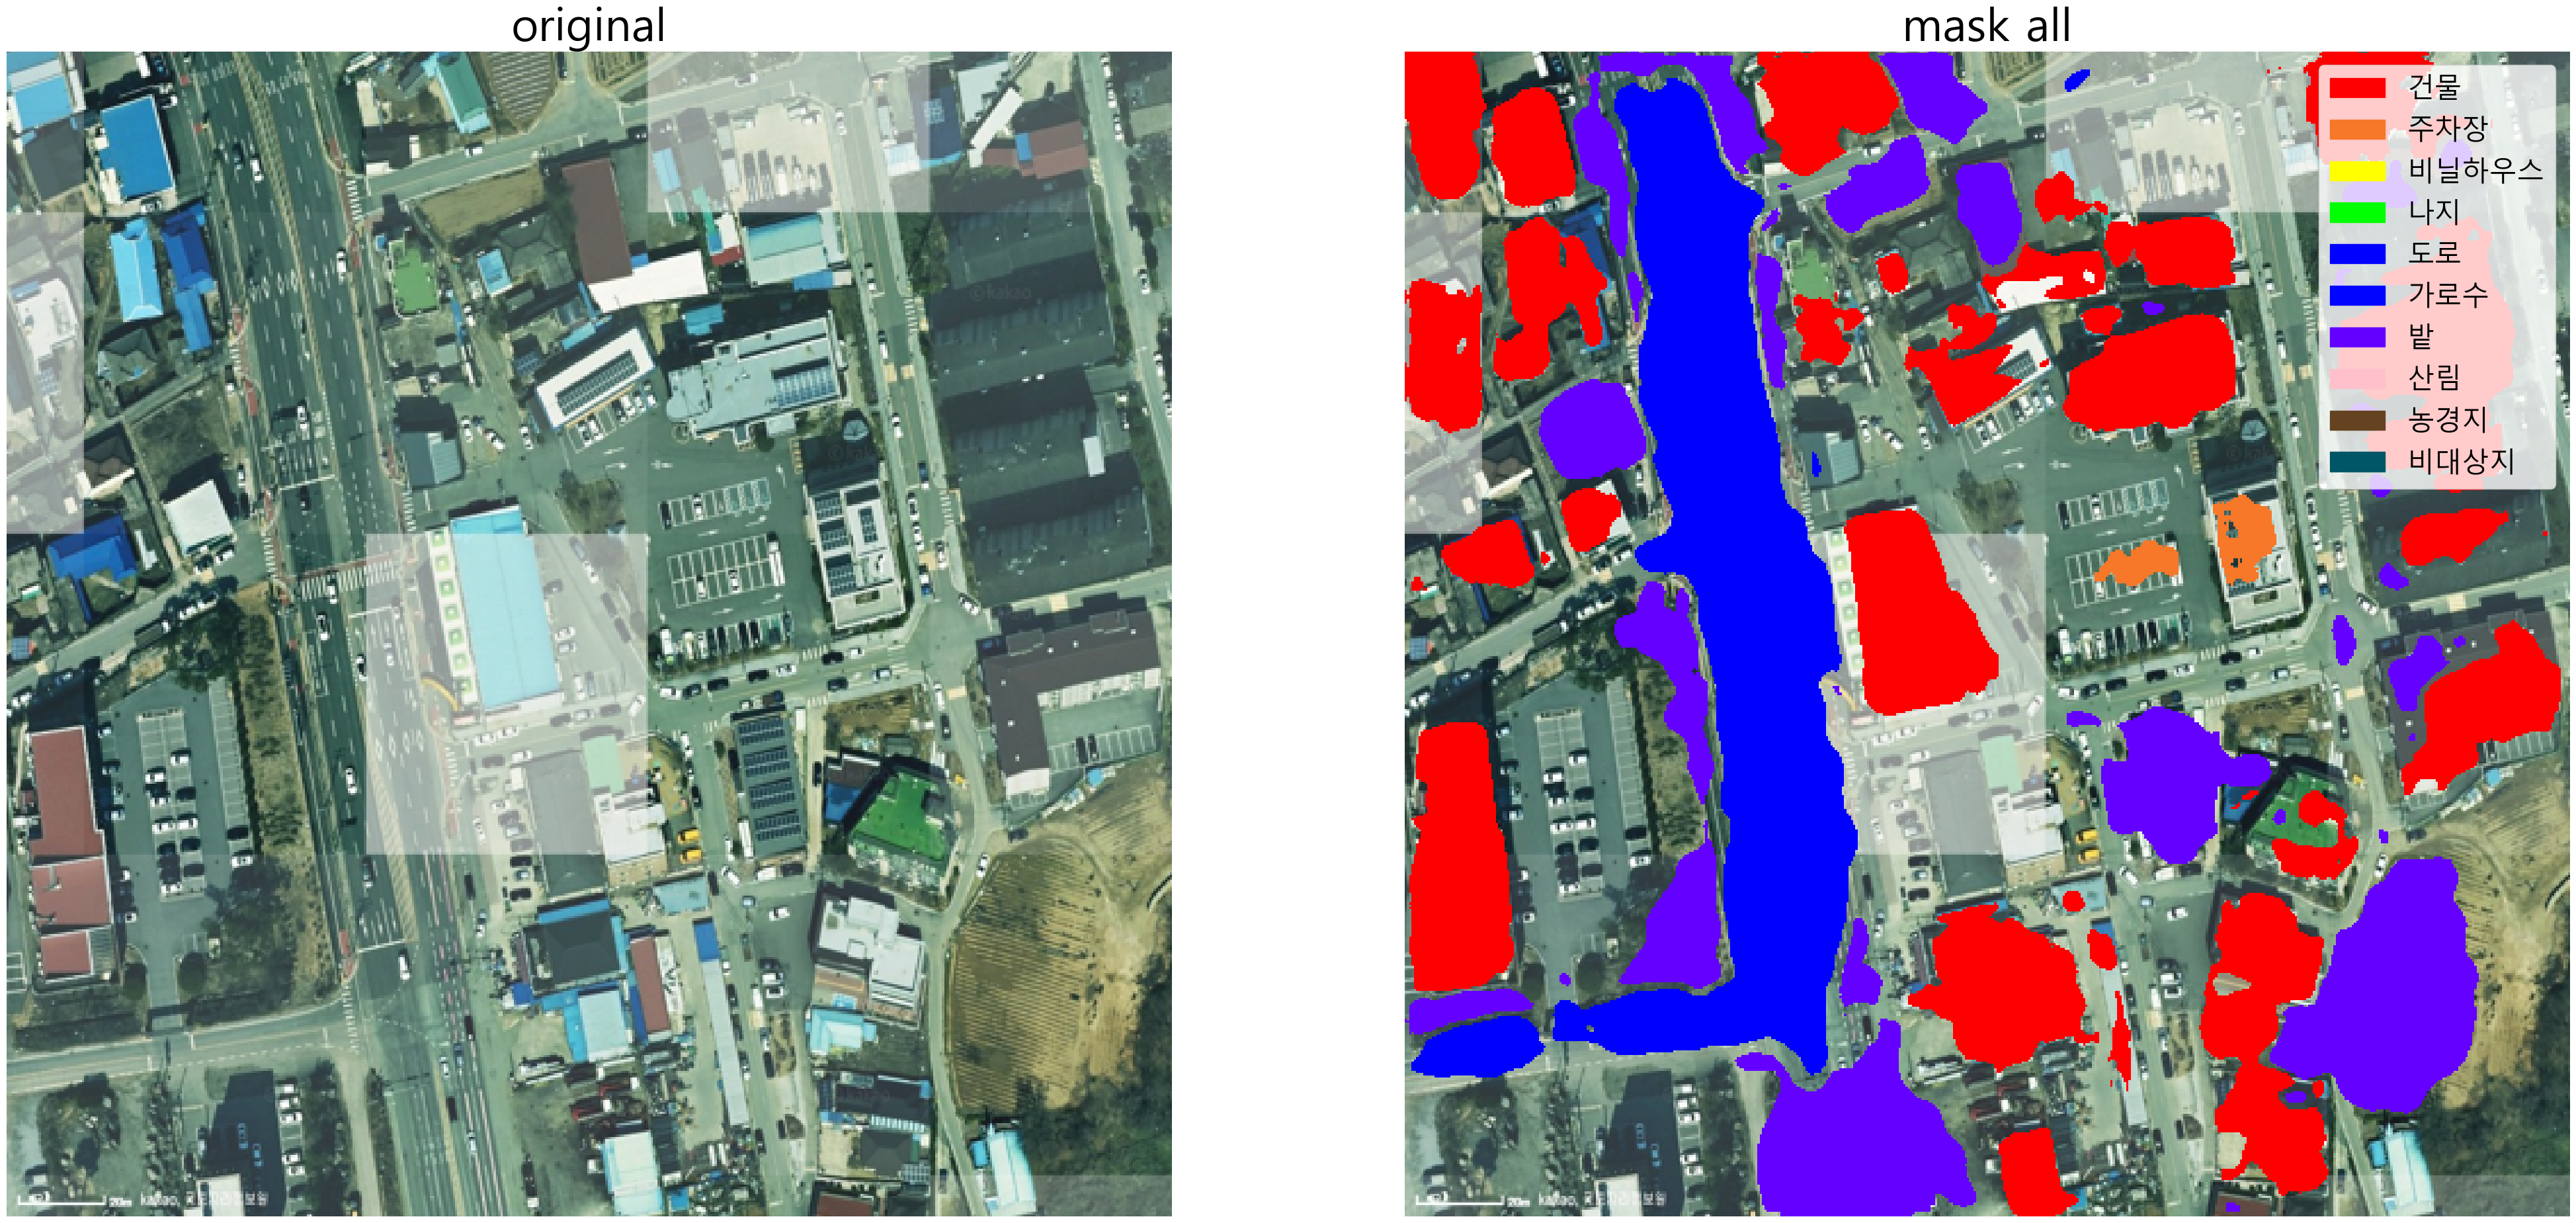

In [10]:
fig = plt.figure(figsize=(50,50))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(original_img)
ax1.set_title('original',fontsize=fontsize)
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask3)
ax2.set_title('mask all',fontsize=fontsize)
ax2.axis("off")

#plt.show(original_img)
#plt.imshow(mask3)

handles = []
labels = []
for i in range(10):
	handles.append(Rectangle((0,0),1,1, color=tuple([COLOR[i][j]/255 for j in range(3)])))
	labels.append(class_name[i])
		

plt.legend(handles,labels, fontsize = 30)
